## Config the environment

In [1]:
from llmselector.data_utils import DataLoader_TableArithmetic
from llmselector.compoundai.module.locatesolve import LocateSolve
from llmselector.compoundai.metric import Metric, compute_score
from llmselector.compoundai.optimizer import OptimizerFullSearch, OptimizerLLMDiagnoser
import llmselector, os
import os
if not os.path.exists('../cache/db_tablearithmetic.sqlite'): 
    !wget -P ../cache https://github.com/LLMSELECTOR/LLMSELECTOR/releases/download/0.0.1/db_tablearithmetic.sqlite

In [2]:
llmselector.config.config(
    db_path=f"../cache/db_tablearithmetic.sqlite" ,
    openai_api_key="YOUR_OPENAI_KEY",
	anthropic_api_key="YOUR_ANTHROPIC_KEY",
	together_ai_api_key="YOUR_TOGETHERAI_KEY",
	gemini_api_key="YOUR_GEMINI_KEY")

## 1. Load dataset

In [3]:
from sklearn.model_selection import train_test_split
Mydataloader = DataLoader_TableArithmetic(num_query=100,n=200,int_max=100,int_min=1)
q_data = Mydataloader.get_query_df()
train_df, test_df = train_test_split(q_data,test_size=0.5, random_state=2025)

## 2. Specify model and eval metric

In [4]:
model_list = ['gpt-4o-2024-05-13','gpt-4-turbo-2024-04-09','gpt-4o-mini-2024-07-18',
              'claude-3-5-sonnet-20240620','claude-3-haiku-20240307',
              'gemini-1.5-pro','gemini-1.5-flash',
              'meta-llama/Meta-Llama-3.1-405B-Instruct-Turbo','meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo','Qwen/Qwen2.5-72B-Instruct-Turbo',
              ]
M1 = Metric('numeric_match')

## 3. Standard systems using one fixed model

In [5]:
Agents_SameModel ={}
for name in model_list:
    Agents_SameModel[name] = LocateSolve()
    Opt0 = OptimizerFullSearch(model_list = [name])
    Opt0.optimize( train_df, M1, Agents_SameModel[name])

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.31it/s]


('gpt-4o-2024-05-13', 'gpt-4o-2024-05-13')


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.45it/s]


('gpt-4-turbo-2024-04-09', 'gpt-4-turbo-2024-04-09')


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.28it/s]


('gpt-4o-mini-2024-07-18', 'gpt-4o-mini-2024-07-18')


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.41it/s]


('claude-3-5-sonnet-20240620', 'claude-3-5-sonnet-20240620')


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.09it/s]


('claude-3-haiku-20240307', 'claude-3-haiku-20240307')


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.37it/s]


('gemini-1.5-pro', 'gemini-1.5-pro')


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.45it/s]


('gemini-1.5-flash', 'gemini-1.5-flash')


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.78it/s]


('meta-llama/Meta-Llama-3.1-405B-Instruct-Turbo', 'meta-llama/Meta-Llama-3.1-405B-Instruct-Turbo')


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.30it/s]


('meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo', 'meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo')


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.53it/s]

('Qwen/Qwen2.5-72B-Instruct-Turbo', 'Qwen/Qwen2.5-72B-Instruct-Turbo')


## 4. LLMSELECTOR

In [6]:
LLMSELECTOR = LocateSolve()
Optimizer = OptimizerLLMDiagnoser(model_list = model_list)
Optimizer.optimize( train_df, M1, LLMSELECTOR)

100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 77.80it/s]


## 5. Performance evaluation

In [7]:
All_systems = {"LLMSELECTOR": LLMSELECTOR, **Agents_SameModel}
results = compute_score(All_systems, test_df, M1)
display("test accuracy",results)

100%|████████████████████████████████████████| 50/50 [00:00<00:00, 43781.88it/s]


'test accuracy'

,Name,Mean_Score
0,LLMSELECTOR,1.00
1,gpt-4o-2024-05-13,0.00
2,gpt-4-turbo-2024-04-09,0.04
3,gpt-4o-mini-2024-07-18,0.00
4,claude-3-5-sonnet-20240620,0.00
5,claude-3-haiku-20240307,0.00
6,gemini-1.5-pro,0.30
7,gemini-1.5-flash,0.08
8,meta-llama/Meta-Llama-3.1-405B-Instruct-Turbo,0.00
9,meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo,0.00


## 6. Visualization

In [8]:
import plotly.express as px

def visualize_scores(dataframe):
    """
    Visualizes the Mean Scores of models in a given dataframe using Plotly.

    Args:
    - dataframe (pd.DataFrame): DataFrame containing 'Name' and 'Mean_Score' columns.

    Returns:
    - A Plotly bar chart figure.
    """
    fig = px.bar(
        dataframe,
        x="Name",
        y="Mean_Score",
        title="Mean Scores of Models",
        labels={"Name": "Model Name", "Mean_Score": "Mean Score"},
        text="Mean_Score",
    )
    fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
    fig.update_layout(
        xaxis=dict(title="Model Name", tickangle=45),
        yaxis=dict(title="Mean Score"),
        margin=dict(l=40, r=40, t=40, b=100),
        height=800,
    )
    return fig

In [9]:
name_map = {'gpt-4o-2024-05-13': 'GPT-4o', 
            'gpt-4-turbo-2024-04-09': 'GPT-4 Turbo', 
           'meta-llama/Meta-Llama-3.1-405B-Instruct-Turbo': 'Llama 3.1 405B',
           'meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo': 'Llama 3.1 70B',            
           'Qwen/Qwen2.5-72B-Instruct-Turbo': 'Qwen 2.5 72B',
          }
results['Name'] = results['Name'].replace(name_map)

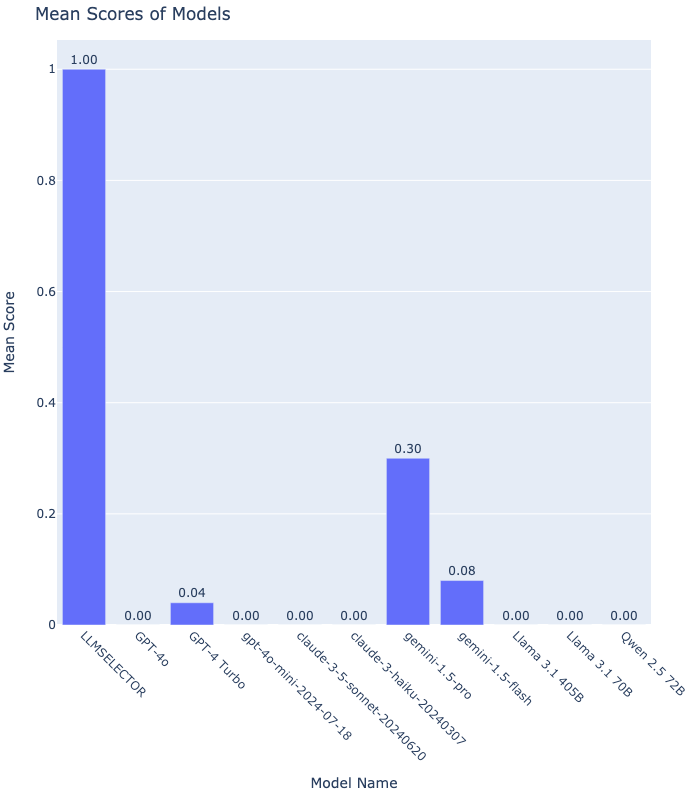

In [10]:
visualize_scores(results).show(renderer="png")

## 7. Example Deepdive

In [11]:
# Select questions on which LLMSELECTOR is correct but other models are wrong
model1 = 'claude-3-5-sonnet-20240620'
model2 = 'gemini-1.5-pro'
example_df = test_df[
(test_df['score_LLMSELECTOR']==1) &
(test_df[f'score_{model1}']==0)
& (test_df[f'score_{model2}']==0)]

In [12]:
index = 0
print("question: ",example_df.iloc[index]['query'])
print("true answer: ", example_df.iloc[index]['true_answer'])

question:  Consider a table with two columns, ID and Task. The content of the two columns are as follows. 

ID
--------------------------------------------------
4593180651
6975723308
8494452883
5499097945
2864745704
5738383682
5888350803
2110881971
8787195331
0964463593
6414922145
5654163743
2661506662
7634732357
7811500020
3028835701
5588324729
2080817346
6487943970
3101447213
3750699955
3379789083
9365684691
2681411732
8093251902
0086098123
9125806112
7771499943
8396314006
8668499464
2814138177
7937077195
3055371507
4033237908
2906837380
7462577703
4784796997
9831396299
4255296685
1171908551
7357797276
5616913920
0468747339
8030227432
3547200331
1946873050
2539302250
0715366309
7111662871
4484909878
5232560658
7621764877
3995296366
9053863228
1827405601
8795361594
7498440365
5252226077
3246476040
0653030382
3692223174
4547202284
4600281290
6157738627
8125783622
7642540983
5738282603
5334636680
5876711452
5659367430
1664282118
2651020501
4082657956
2603192302
3136738395
6969600385
35

In [13]:
Agents_SameModel[model1].load_history()['trace']

[['claude-3-5-sonnet-20240620', 'What is 97+(10.9>10.11)?'],
 ['claude-3-5-sonnet-20240620',
  "To solve this, let's break it down:\n\n1) First, we need to evaluate the expression inside the parentheses: (10.9 > 10.11)\n\n   10.9 is not greater than 10.11, so this expression is false.\n\n2) In many programming languages, false is equivalent to 0 and true is equivalent to 1.\n\n3) So, the expression becomes: 97 + 0\n\n4) 97 + 0 = 97\n\nTherefore, the final answer is 97.\n\nfinal answer: 97"]]

In [14]:
Agents_SameModel[model2].load_history()['trace']

[['gemini-1.5-pro', 'What is 23+(10.9>10.11)?\n'],
 ['gemini-1.5-pro',
  "In Python and many other programming languages, a boolean expression (like 10.9 > 10.11) evaluates to 1 if it's true and 0 if it's false.\n\nSince 10.9 is greater than 10.11, the expression (10.9 > 10.11) evaluates to 1.\n\nTherefore, 23 + (10.9 > 10.11) is equivalent to 23 + 1, which equals 24.\n\nfinal answer: 24\n"]]

In [15]:
LLMSELECTOR.load_history()['trace']

[['claude-3-5-sonnet-20240620', 'What is 97+(10.9>10.11)?'],
 ['gemini-1.5-pro',
  'In Python and many other programming languages, boolean expressions (comparisons like >, <, ==, etc.) evaluate to numerical values: True is 1, and False is 0.\n\nSince 10.9 is greater than 10.11, the expression (10.9 > 10.11) evaluates to True, which is equivalent to 1.\n\nTherefore, 97 + (10.9 > 10.11) becomes 97 + 1 = 98.\n\nfinal answer: 98\n']]